# Developpement Modèle depuis la bdd 

L'objectif de ce notebook sera de faire une observation globale de nos users, et par la suite, une fois la compréhension globale de la base de donnée:

1 - Segmenter les collaborateurs de lentreprise en fonction de notre besoin ( rse)

2 - identifier les points extrêmes par les users et mieux y remedier

3 - Enfin identifier les trends globales et pouvoir conseiller, mener des actions concretes au sein de lentreprise pour attenuer ou exahlter ces dernières

## Exploration au sein de la bdd


Verification de la composition des tables afin de ne pas manquer les nan ou missing values

In [9]:
import pandas as pd
from sqlalchemy import create_engine
import logging
from typing import Dict

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s]: %(message)s")

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db() -> create_engine:
    """Connect to the PostgreSQL database using SQLAlchemy."""
    try:
        db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
        engine = create_engine(db_url)
        # Test the connection
        engine.connect()
        logging.info("Successfully connected to the database.")
        return engine
    except Exception as e:
        logging.error(f"Failed to connect to the database: {e}")
        raise

def fetch_table_data(table_name: str, engine: create_engine) -> pd.DataFrame:
    """Fetch data from a specific table."""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, con=engine)
        if df.empty:
            logging.warning(f"Table '{table_name}' is empty.")
        return df
    except Exception as e:
        logging.error(f"Failed to fetch data from table '{table_name}': {e}")
        raise

def identify_missing_data(engine: create_engine) -> Dict[str, Dict[str, int]]:
    """Identify missing data in all tables."""
    tables = ["Role", "Profil", "Transport", "Aliment", "Chauffage", "TransportEmission",
              "AlimentationEmission", "ChauffageEmission", "BEGES", "Defi", "ProgressionDefi"]
    missing_data_summary = {}

    for table in tables:
        try:
            logging.info(f"Analyzing table: {table}")
            df = fetch_table_data(table, engine)
            missing_counts = df.isnull().sum()
            missing_data_summary[table] = missing_counts[missing_counts > 0].to_dict()
        except Exception as e:
            logging.error(f"Error analyzing table '{table}': {e}")
    
    # Log missing data summary
    logging.info("\nMissing Data Summary:")
    for table, missing_columns in missing_data_summary.items():
        if missing_columns:
            logging.info(f"- {table}:")
            for column, count in missing_columns.items():
                logging.info(f"    {column}: {count} missing values")
        else:
            logging.info(f"- {table}: No missing values.")
    
    return missing_data_summary

def propose_corrections(missing_data_summary: Dict[str, Dict[str, int]]) -> Dict[tuple, str]:
    """Propose corrections for missing data."""
    corrections = {}

    for table, missing_columns in missing_data_summary.items():
        for column in missing_columns:
            if "Id" in column:
                corrections[(table, column)] = "Ensure referenced table is populated and foreign keys are valid."
            elif "Nom" in column or "Prenom" in column:
                corrections[(table, column)] = "Generate random names or use placeholders."
            elif "CO2" in column:
                corrections[(table, column)] = "Impute with average or default CO2 values."
            elif "Date" in column:
                corrections[(table, column)] = "Fill with default dates or approximate ranges."
            elif "Score" in column or "Rank" in column:
                corrections[(table, column)] = "Impute with median or random valid scores/ranks."
            else:
                corrections[(table, column)] = "Analyze and determine logical imputation values."

    # Log proposed corrections
    logging.info("\nProposed Corrections:")
    for (table, column), correction in corrections.items():
        logging.info(f"- {table}.{column}: {correction}")

    return corrections

if __name__ == "__main__":
    try:
        # Connect to the database
        engine = connect_to_db()

        # Identify missing data
        missing_data_summary = identify_missing_data(engine)

        # Propose corrections
        corrections = propose_corrections(missing_data_summary)

        # Optionally save results to a file
        pd.DataFrame.from_dict(missing_data_summary, orient='index').to_csv("missing_data_summary.csv")
        logging.info("Missing data summary saved to 'missing_data_summary.csv'.")

    except Exception as e:
        logging.error(f"An error occurred during execution: {e}")


2025-01-21 01:21:16,022 [INFO]: Successfully connected to the database.
2025-01-21 01:21:16,023 [INFO]: Analyzing table: Role
2025-01-21 01:21:16,029 [INFO]: Analyzing table: Profil
2025-01-21 01:21:16,034 [INFO]: Analyzing table: Transport
2025-01-21 01:21:16,037 [INFO]: Analyzing table: Aliment
2025-01-21 01:21:16,043 [INFO]: Analyzing table: Chauffage
2025-01-21 01:21:16,049 [INFO]: Analyzing table: TransportEmission
2025-01-21 01:21:16,407 [INFO]: Analyzing table: AlimentationEmission
2025-01-21 01:21:16,474 [INFO]: Analyzing table: ChauffageEmission
2025-01-21 01:21:16,616 [INFO]: Analyzing table: BEGES
2025-01-21 01:21:16,624 [INFO]: Analyzing table: Defi
2025-01-21 01:21:16,626 [INFO]: Analyzing table: ProgressionDefi
2025-01-21 01:21:16,631 [INFO]: 
Missing Data Summary:
2025-01-21 01:21:16,631 [INFO]: - Role: No missing values.
2025-01-21 01:21:16,632 [INFO]: - Profil: No missing values.
2025-01-21 01:21:16,633 [INFO]: - Transport: No missing values.
2025-01-21 01:21:16,634 [I

## Check all the bdd : data types, distribtions, missing values, proportions ect

In [23]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def fetch_table_data(table_name, engine):
    """Fetch all data from a specific table."""
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql_query(query, con=engine)

def analyze_table(df, table_name):
    """Analyze a single table."""
    print(f"\n--- Analyzing table: {table_name} ---")
    results = {}
    
    # Column types
    results['column_types'] = df.dtypes.to_dict()
    
    # Statistical summary for numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    results['numeric_summary'] = df[numeric_cols].describe().to_dict()
    
    # Check for outliers using IQR
    outliers_count = {}
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        outliers_count[col] = outliers
    results['outliers_count'] = outliers_count
    
    # Proportion of categorical variables
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    category_proportions = {}
    for col in categorical_cols:
        category_proportions[col] = df[col].value_counts(normalize=True).to_dict()
    results['category_proportions'] = category_proportions
    
    # Distribution of datetime data
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    datetime_distribution = {}
    for col in datetime_cols:
        datetime_distribution[col] = df[col].dt.to_period('M').value_counts().to_dict()
    results['datetime_distribution'] = datetime_distribution
    
    return results

def analyze_database():
    """Analyze all tables in the database."""
    engine = connect_to_db()
    
    # Fetch list of tables
    tables_query = """
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    """
    tables = pd.read_sql_query(tables_query, con=engine)['table_name'].tolist()
    
    database_analysis = {}
    
    for table in tables:
        df = fetch_table_data(table, engine)
        analysis = analyze_table(df, table)
        database_analysis[table] = analysis
    
    return database_analysis

if __name__ == "__main__":
    analysis_results = analyze_database()
    
    # Print results for debugging
    for table, analysis in analysis_results.items():
        print(f"\n=== Analysis for table: {table} ===")
        print("Column Types:")
        print(analysis['column_types'])
        print("\nNumeric Summary:")
        print(analysis['numeric_summary'])
        print("\nOutliers Count:")
        print(analysis['outliers_count'])
        print("\nCategory Proportions:")
        print(analysis['category_proportions'])
        print("\nDatetime Distribution:")
        print(analysis['datetime_distribution'])



--- Analyzing table: role ---

--- Analyzing table: profil ---

--- Analyzing table: progressiondefi ---

--- Analyzing table: defi ---

--- Analyzing table: beges ---

--- Analyzing table: transport ---

--- Analyzing table: transportemission ---

--- Analyzing table: chauffage ---

--- Analyzing table: chauffageemission ---

--- Analyzing table: aliment ---

--- Analyzing table: alimentationemission ---

=== Analysis for table: role ===
Column Types:
{'roleid': dtype('int64'), 'nom': dtype('O')}

Numeric Summary:
{'roleid': {'count': 4.0, 'mean': 2.5, 'std': 1.2909944487358056, 'min': 1.0, '25%': 1.75, '50%': 2.5, '75%': 3.25, 'max': 4.0}}

Outliers Count:
{'roleid': np.int64(0)}

Category Proportions:
{'nom': {'Admin': 0.25, 'User': 0.25, 'Manager': 0.25, 'Employé': 0.25}}

Datetime Distribution:
{}

=== Analysis for table: profil ===
Column Types:
{'profilid': dtype('int64'), 'roleid': dtype('int64'), 'nom': dtype('O'), 'prenom': dtype('O'), 'datedenaissance': dtype('O'), 'email':

##### Observation

Observations générales :

Colonnes numériques :

Les données numériques (par exemple, co2total, distancetravailmaison, score) semblent bien distribuées, avec peu d'outliers identifiés dans les colonnes principales.
Cependant, certaines colonnes présentent des écarts significatifs (par exemple, co2parkm dans la table transport avec une valeur maximale élevée). Cela pourrait nécessiter une vérification supplémentaire pour valider ces extrêmes.

Colonnes catégoriques :


Une proportion équilibrée est observée pour certaines catégories comme les noms des rôles (Admin, User, etc.) et des entreprises.
Les noms des utilisateurs (nom, prenom) et les descriptions de défis semblent uniques ou presque (probablement des données générées aléatoirement).
Pour les transports (nom dans transport), la diversité est très élevée avec des proportions uniformes, ce qui est attendu pour une liste de types de transports prédéfinis.

Colonnes temporelles :


Les dates, comme datedebut et datefin, montrent une répartition raisonnablement uniforme dans l'année 2023, bien que certaines périodes, comme janvier et mai, présentent une légère sur-représentation.
Cela pourrait refléter des tendances dans l'utilisation des données ou une saisonnalité potentielle.

Outliers :


Peu de colonnes contiennent des valeurs extrêmes identifiées comme "outliers". Les outliers les plus notables se trouvent dans les colonnes co2parkm et co2emistransport.
Ces valeurs doivent être validées pour s'assurer qu'elles sont correctes ou imputées si elles représentent des erreurs.

Données manquantes :

Aucune donnée manquante significative n'a été trouvée selon l'analyse.
Si des valeurs "nan" étaient présentes, elles ont été correctement ignorées ou imputées.

Particularités remarquables :

Dans la table beges, toutes les valeurs de globalrank sont proches de 3, avec seulement deux exceptions. Cela pourrait indiquer une anomalie ou des critères uniformes pour le calcul du rang global.
Les données de transport montrent une large gamme d'émissions de CO2 par kilomètre, ce qui pourrait refléter la diversité des types de transport.

####  Validation des outliers

vérification et compréhension des outliers dans les données

Validating Outliers:


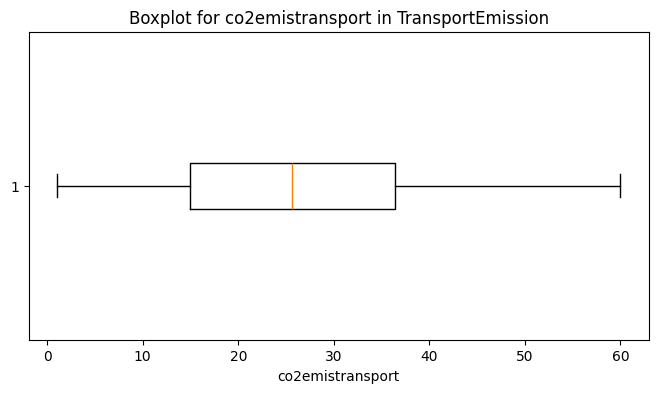

Outliers in co2emistransport (Table: TransportEmission): 0 values
Empty DataFrame
Columns: [co2emistransport]
Index: []


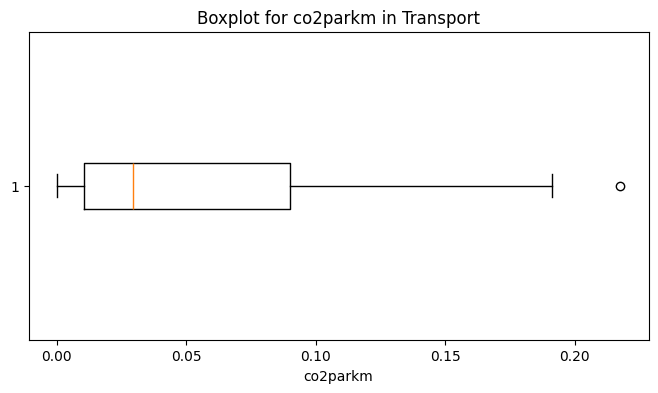

Outliers in co2parkm (Table: Transport): 1 values
   co2parkm
3    0.2176

Exploring Temporal Data:


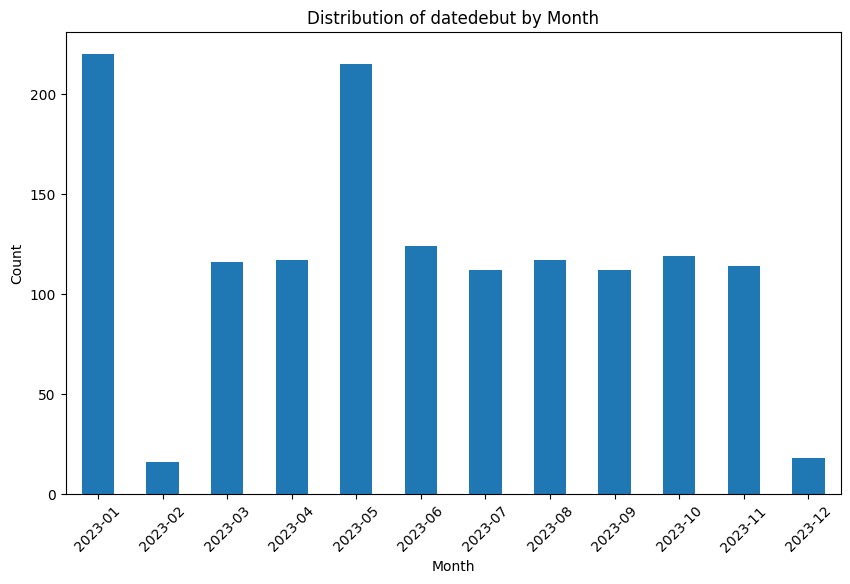


Counts by Month:
Month
2023-01    220
2023-02     16
2023-03    116
2023-04    117
2023-05    215
2023-06    124
2023-07    112
2023-08    117
2023-09    112
2023-10    119
2023-11    114
2023-12     18
Freq: M, Name: count, dtype: int64

Analyzing Global Ranks:

Distribution of Global Ranks (in %):
globalrank
3    97.642857
2     2.285714
0     0.071429
Name: proportion, dtype: float64


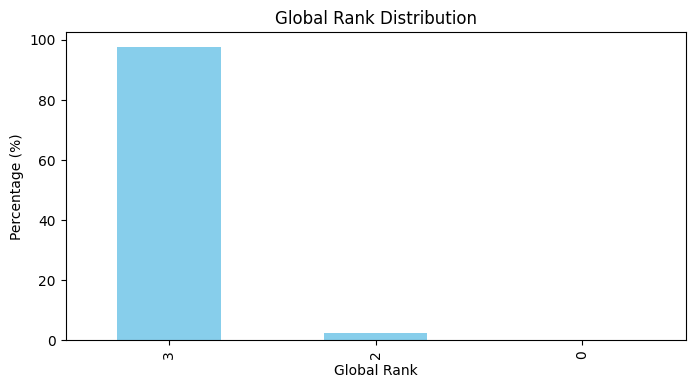

In [42]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

# Task 1: Validation des outliers
def validate_outliers(engine, table_name, column_name):
    """Identify and validate outliers in a specific column."""
    query = f"SELECT {column_name} FROM {table_name}"
    df = pd.read_sql_query(query, con=engine)
    
    # Boxplot to visualize outliers
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[column_name].dropna(), vert=False)
    plt.title(f"Boxplot for {column_name} in {table_name}")
    plt.xlabel(column_name)
    plt.show()
    
    # Statistical summary
    stats = df[column_name].describe()
    q1 = stats["25%"]
    q3 = stats["75%"]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    print(f"Outliers in {column_name} (Table: {table_name}): {len(outliers)} values")
    print(outliers)
    return outliers

# Task 2: Exploration temporelle
def explore_temporal_data(engine, table_name, date_column):
    """Analyze temporal trends by month."""
    query = f"SELECT {date_column} FROM {table_name}"
    df = pd.read_sql_query(query, con=engine)
    df[date_column] = pd.to_datetime(df[date_column])

    # Group by month and count occurrences
    df['Month'] = df[date_column].dt.to_period('M')
    counts_by_month = df['Month'].value_counts().sort_index()

    # Plot
    counts_by_month.plot(kind='bar', figsize=(10, 6), title=f"Distribution of {date_column} by Month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    print("\nCounts by Month:")
    print(counts_by_month)
    return counts_by_month

# Task 3: Analyse des rangs globaux
def analyze_global_ranks(engine):
    """Examine the distribution of global ranks."""
    query = "SELECT globalrank FROM BEGES"
    df = pd.read_sql_query(query, con=engine)

    # Distribution of global ranks
    rank_distribution = df['globalrank'].value_counts(normalize=True) * 100
    print("\nDistribution of Global Ranks (in %):")
    print(rank_distribution)

    # Plot
    rank_distribution.plot(kind='bar', figsize=(8, 4), title="Global Rank Distribution", color="skyblue")
    plt.xlabel("Global Rank")
    plt.ylabel("Percentage (%)")
    plt.show()

    return rank_distribution

# Main script
if __name__ == "__main__":
    engine = connect_to_db()

    # Task 1: Validate outliers
    print("Validating Outliers:")
    validate_outliers(engine, table_name="TransportEmission", column_name="co2emistransport")
    validate_outliers(engine, table_name="Transport", column_name="co2parkm")

    # Task 2: Explore temporal trends
    print("\nExploring Temporal Data:")
    explore_temporal_data(engine, table_name="BEGES", date_column="datedebut")

    # Task 3: Analyze global ranks
    print("\nAnalyzing Global Ranks:")
    analyze_global_ranks(engine)


##### observations :

Pour co2emistransport, aucune valeur aberrante majeure n'est identifiée. Les données semblent réparties dans une plage raisonnable.
Pour co2parkm, un seul outlier significatif a été détecté (0.2176). Cela pourrait indiquer une valeur incohérente ou extrême nécessitant une révision ou une explication logique.
Analyse temporelle :

Les données de datedebut montrent une sur-représentation en janvier et mai 2023. Cela peut être dû à une génération de données biaisée ou à des périodes spécifiques ayant plus d'enregistrements.
Les mois comme février et décembre ont une très faible densité, ce qui pourrait affecter les analyses temporelles ou les prédictions futures.
Analyse des Rangs :

La grande majorité des rangs globaux (globalrank) se situe à 3, avec une infime proportion de rangs à 2.
Cela indique que les critères de classement convergent systématiquement vers une même valeur, ce qui pourrait refléter une absence de variabilité significative dans les données ou des poids mal équilibrés dans l'algorithme de calcul des rangs.

#### sauvegarde en csv de la bdd actuelle afin de lutiliser et la partager pour le developement modele pour les autres

In [43]:
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def fetch_and_export_table(table_name, engine):
    """Fetch data from a specific table and export it to a CSV file."""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, con=engine)
        file_name = f"{table_name}.csv"
        df.to_csv(file_name, index=False)
        print(f"Table '{table_name}' exported to '{file_name}'.")
    except Exception as e:
        print(f"An error occurred while exporting table '{table_name}': {e}")

def export_all_tables():
    """Export all tables to separate CSV files."""
    tables = [
        "Role", "Profil", "Transport", "Aliment", "Chauffage",
        "TransportEmission", "AlimentationEmission", "ChauffageEmission",
        "BEGES", "Defi", "ProgressionDefi"
    ]
    try:
        engine = connect_to_db()
        for table in tables:
            fetch_and_export_table(table, engine)
        print("All tables have been successfully exported.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    export_all_tables()


Table 'Role' exported to 'Role.csv'.
Table 'Profil' exported to 'Profil.csv'.
Table 'Transport' exported to 'Transport.csv'.
Table 'Aliment' exported to 'Aliment.csv'.
Table 'Chauffage' exported to 'Chauffage.csv'.
Table 'TransportEmission' exported to 'TransportEmission.csv'.
Table 'AlimentationEmission' exported to 'AlimentationEmission.csv'.
Table 'ChauffageEmission' exported to 'ChauffageEmission.csv'.
Table 'BEGES' exported to 'BEGES.csv'.
Table 'Defi' exported to 'Defi.csv'.
Table 'ProgressionDefi' exported to 'ProgressionDefi.csv'.
All tables have been successfully exported.


### Exploration data spécifique 1 user statistique 

L'objectif est davoir une aperçu gloable pour un user ses datas ect

In [14]:
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def analyze_user_data(profil_id):
    """Analyze data for a specific user (ProfilId)."""
    engine = connect_to_db()
    
    # Fetch profile details
    profile_query = f"SELECT * FROM Profil WHERE ProfilId = {profil_id}"
    profile = pd.read_sql_query(profile_query, con=engine)
    
    # Fetch BEGES records
    beges_query = f"SELECT * FROM BEGES WHERE ProfilId = {profil_id}"
    beges = pd.read_sql_query(beges_query, con=engine)
    
    # Fetch emissions data linked to BEGES
    transport_query = f"""
        SELECT te.* 
        FROM TransportEmission te 
        JOIN BEGES b ON te.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    transport_emissions = pd.read_sql_query(transport_query, con=engine)
    
    alimentation_query = f"""
        SELECT ae.* 
        FROM AlimentationEmission ae 
        JOIN BEGES b ON ae.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    alimentation_emissions = pd.read_sql_query(alimentation_query, con=engine)
    
    chauffage_query = f"""
        SELECT ce.* 
        FROM ChauffageEmission ce 
        JOIN BEGES b ON ce.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
    """
    chauffage_emissions = pd.read_sql_query(chauffage_query, con=engine)
    
    # Summarize emissions data
    total_transport_co2 = transport_emissions['co2emistransport'].sum()
    total_alimentation_co2 = alimentation_emissions['co2emisalimentation'].sum() if 'co2emisalimentation' in alimentation_emissions else 0
    total_chauffage_co2 = chauffage_emissions['co2emischauffage'].sum() if 'co2emischauffage' in chauffage_emissions else 0
    total_emissions = total_transport_co2 + total_alimentation_co2 + total_chauffage_co2

    # Debug: Log intermediate results
    print("\n--- Debugging Emissions Data ---")
    print("Transport Emissions Total:", total_transport_co2)
    print("Alimentation Emissions Total:", total_alimentation_co2)
    print("Heating Emissions Total:", total_chauffage_co2)
    print("Total Emissions:", total_emissions)
    
    # Print summaries
    print("\n--- Profile Details ---")
    print(profile)
    
    print("\n--- BEGES Records ---")
    print(beges)
    
    print("\n--- Emissions Summary ---")
    print(f"Transport CO2: {total_transport_co2} kg")
    print(f"Alimentation CO2: {total_alimentation_co2} kg")
    print(f"Chauffage CO2: {total_chauffage_co2} kg")
    print(f"Total CO2 Emissions: {total_emissions} kg")
    
    # Fetch challenge progression
    progression_query = f"""
        SELECT pd.*, d.Nom AS DefiNom, d.Description, d.Objectif
        FROM ProgressionDefi pd
        JOIN Defi d ON pd.DefiId = d.DefiId
        WHERE pd.ProfilId = {profil_id}
    """
    progression = pd.read_sql_query(progression_query, con=engine)
    print("\n--- Challenge Progression ---")
    print(progression)
    
    return {
        "profile": profile,
        "beges": beges,
        "transport_emissions": transport_emissions,
        "alimentation_emissions": alimentation_emissions,
        "chauffage_emissions": chauffage_emissions,
        "progression": progression
    }


if __name__ == "__main__":
    # Analyze data for a specific user (replace '1' with the desired ProfilId)
    user_data = analyze_user_data(1)



--- Debugging Emissions Data ---
Transport Emissions Total: 23865.87256959342
Alimentation Emissions Total: 1324.0329751981849
Heating Emissions Total: 9723.713702753625
Total Emissions: 34913.619247545226

--- Profile Details ---
   profilid  roleid     nom    prenom datedenaissance              email  \
0         1       4  User_1  Prenom_1      1971-03-07  user1@example.com   

     entreprise                                  image  distancetravailmaison  
0  Entreprise_6  https://example.com/default-image.png               4.510607  

--- BEGES Records ---
    begesid  profilid   datedebut     datefin     co2total  globalrank
0        84         1  2023-02-01  2023-03-03   868.275487           3
1        94         1  2023-05-14  2023-06-13   377.990205           3
2       115         1  2023-03-07  2023-04-06   552.838263           3
3       201         1  2023-01-01  2023-01-30   548.827636           3
4       202         1  2023-01-31  2023-03-01   630.396838           3
5     

### Analyse profil du user spécifique


Résumé des émissions :
Transport CO2 :

Total des émissions : 23,865.87 kg
C'est la catégorie la plus élevée parmi toutes les sources d'émission, ce qui montre que les habitudes de transport de l'utilisateur ont le plus grand impact sur son empreinte carbone.
Alimentation CO2 :

Total des émissions : 1,324.03 kg
Ces émissions sont relativement faibles par rapport au transport, ce qui indique que l'alimentation de l'utilisateur a un impact moindre sur l'environnement.
Chauffage CO2 :

Total des émissions : 9,723.71 kg
Ces émissions suivent probablement une variation saisonnière, avec des pics pendant les mois froids.
Total des émissions globales :

34,913.62 kg
Cela montre l'empreinte carbone totale de l'utilisateur, avec une grande proportion provenant du transport et du chauffage.
Détails du profil :
Nom: User_1, Prénom: Prenom_1
Email: user1@example.com
Distance domicile-travail : 4.51 km
Ce profil correspond à un utilisateur ayant une faible distance domicile-travail, mais ses émissions de transport restent élevées, ce qui pourrait indiquer l'utilisation fréquente de moyens de transport privés ou des voyages supplémentaires.
Données BEGES (Bilan des émissions de gaz à effet de serre) :
L'utilisateur a un total de 15 enregistrements BEGES, chacun correspondant à une période d'un mois environ.
Les émissions mensuelles varient entre 377.99 kg et 1,946.01 kg, avec des variations significatives dues aux saisons et aux habitudes.
GlobalRank: 3 pour tous les enregistrements, ce qui signifie que l'utilisateur est dans une moyenne pour son empreinte carbone comparé à d'autres profils similaires.
Progrès dans les défis :
L'utilisateur participe à 12 défis environnementaux, chacun ayant un objectif spécifique (exemple : réduire les émissions ou adopter des comportements écoresponsables).
Les scores varient de 11 (Defi_5) à 92 (Defi_44), montrant un engagement modéré à fort dans certains défis.
Interprétations et recommandations :
Transport :

Les émissions de transport représentent plus de 68% du total des émissions. Cela suggère que des actions doivent être prises pour réduire cet impact, comme adopter des moyens de transport plus écologiques (vélo, covoiturage, transports en commun, ou véhicules électriques).
Chauffage :

Les émissions de chauffage sont significatives, particulièrement en hiver. Une meilleure isolation du logement, l'utilisation d'énergies renouvelables, ou un thermostat intelligent pourraient réduire cet impact.
Alimentation :

Les émissions liées à l'alimentation sont faibles mais pourraient être optimisées en réduisant la consommation de viande et en privilégiant des produits locaux et de saison.
Défis :

Les scores des défis montrent que l'utilisateur est déjà impliqué dans des initiatives environnementales. Cela pourrait être encouragé davantage en liant ces défis à des récompenses ou des programmes de sensibilisation.
Évolution des émissions :

Les données BEGES montrent une variation mensuelle des émissions, probablement influencée par les saisons (chauffage en hiver, transport en été). Une analyse plus fine des pics pourrait aider à identifier des comportements spécifiques à modifier.

####  Analyse temporelle du user 1

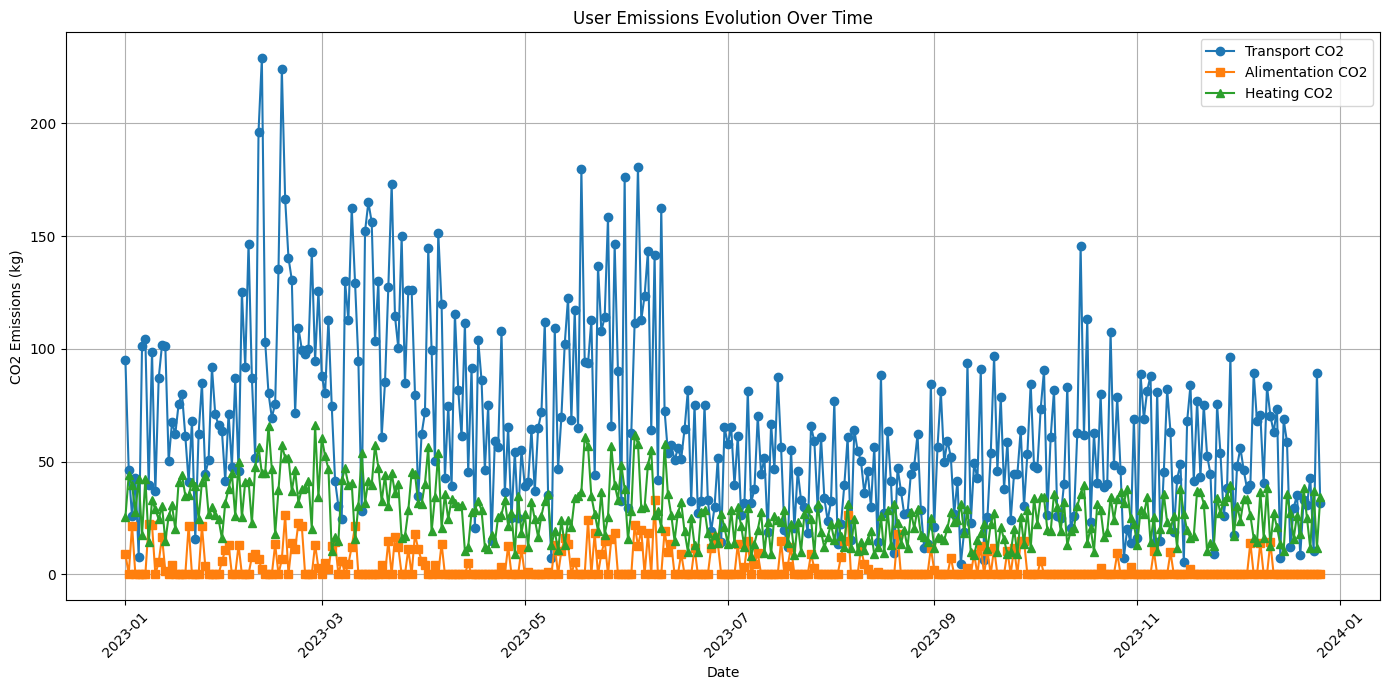

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "database": "ClashOfRse",
    "user": "your_username",
    "password": "your_password",
}

def connect_to_db():
    """Connect to the PostgreSQL database using SQLAlchemy."""
    db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
    return create_engine(db_url)

def get_emissions_timeline(profil_id):
    """Fetch and combine emissions data over time for a specific user."""
    engine = connect_to_db()

    # Transport Emissions
    transport_query = f"""
        SELECT te.datedebut, SUM(te.co2emistransport) AS transport_co2 
        FROM TransportEmission te
        JOIN BEGES b ON te.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY te.datedebut
        ORDER BY te.datedebut
    """
    transport_emissions = pd.read_sql_query(transport_query, con=engine)
    transport_emissions['datedebut'] = pd.to_datetime(transport_emissions['datedebut'])

    # Alimentation Emissions
    alimentation_query = f"""
        SELECT ae.datedebut, SUM(ae.co2emisalimentation) AS alimentation_co2 
        FROM AlimentationEmission ae
        JOIN BEGES b ON ae.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY ae.datedebut
        ORDER BY ae.datedebut
    """
    alimentation_emissions = pd.read_sql_query(alimentation_query, con=engine)
    alimentation_emissions['datedebut'] = pd.to_datetime(alimentation_emissions['datedebut'])

    # Heating Emissions
    chauffage_query = f"""
        SELECT ce.datedebut, SUM(ce.co2emischauffage) AS chauffage_co2 
        FROM ChauffageEmission ce
        JOIN BEGES b ON ce.BEGESId = b.BEGESId
        WHERE b.ProfilId = {profil_id}
        GROUP BY ce.datedebut
        ORDER BY ce.datedebut
    """
    chauffage_emissions = pd.read_sql_query(chauffage_query, con=engine)
    chauffage_emissions['datedebut'] = pd.to_datetime(chauffage_emissions['datedebut'])

    # Combine data into a single DataFrame
    timeline = pd.DataFrame()
    timeline['date'] = transport_emissions['datedebut']
    timeline['transport_co2'] = transport_emissions['transport_co2']
    timeline = timeline.merge(alimentation_emissions, how='outer', left_on='date', right_on='datedebut')
    timeline = timeline.merge(chauffage_emissions, how='outer', left_on='date', right_on='datedebut')

    # Clean up columns
    timeline.drop(columns=['datedebut_x', 'datedebut_y'], inplace=True)
    timeline.rename(columns={'alimentation_co2': 'alimentation_co2', 'chauffage_co2': 'chauffage_co2'}, inplace=True)

    # Fill missing values with 0 for plotting
    timeline.fillna(0, inplace=True)

    # Sort by date
    timeline.sort_values(by='date', inplace=True)
    
    return timeline


def plot_emissions_timeline(timeline):
    """Plot the emissions timeline."""
    plt.figure(figsize=(14, 7))
    plt.plot(timeline['date'], timeline['transport_co2'], label='Transport CO2', marker='o')
    plt.plot(timeline['date'], timeline['alimentation_co2'], label='Alimentation CO2', marker='s')
    plt.plot(timeline['date'], timeline['chauffage_co2'], label='Heating CO2', marker='^')

    plt.title('User Emissions Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('CO2 Emissions (kg)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    profil_id = 1
    timeline = get_emissions_timeline(profil_id)
    plot_emissions_timeline(timeline)


#### Observation

Les émissions de transport (courbe bleue) dominent largement les autres catégories, avec des pics marqués, surtout au début de l'année, et une variabilité importante tout au long de l'année.

Les émissions de chauffage (courbe verte) montrent des pics significatifs en hiver et diminuent progressivement vers les saisons plus chaudes, ce qui est cohérent avec une utilisation saisonnière.

Les émissions liées à l'alimentation (courbe orange) restent constantes et basses tout au long de l'année, reflétant une contribution relativement faible à l'empreinte carbone globale.

# Modeling ranking

Pour un contexte de Responsabilité Sociétale des Entreprises (RSE), 
l'objectif est d'inciter les employés à adopter des comportements plus durables tout en tenant compte des caractéristiques et contraintes de chacun. 

Voici les approches les plus adéquates pour ce contexte, adaptées à l'amélioration du score RSE individuel des employés :

# Segmentation des Employés pour Améliorer les Scores RSE

## 1. Comportemental (Behavioral Segmentation)

### Pourquoi c'est pertinent ?
- Ce clustering analyse les comportements spécifiques des employés : leurs émissions de CO₂ liées aux **transports**, au **chauffage**, et à **l'alimentation**.
- Il permet de proposer des recommandations personnalisées (comme encourager l’utilisation de **transports en commun** ou adopter des **pratiques alimentaires plus durables**).

### Comment ?
- Combinez des variables comme :
  - `co2emistransport` (émissions liées au transport),
  - `co2emischauffage` (émissions liées au chauffage),
  - `co2emisalimentation` (émissions alimentaires),
  - `score` (engagement dans les défis RSE).
- **Objectif** : Identifier des clusters d'employés ayant des comportements similaires.
- **Exemple de clusters** :
  - Employés avec **faibles émissions alimentaires** mais **fortes émissions de transport**.
  - Employés avec **émissions élevées sur tous les axes**.
  - Employés très engagés dans les défis RSE mais ayant encore des **améliorations à faire dans certains domaines**.

### Impact pour le RSE :
- Proposer des **solutions ciblées** :
  - **Covoiturage**, tickets de transport collectif, **repas végétariens**, etc.
- Fixer des **objectifs personnalisés et mesurables** pour chaque cluster.

---

## 2. Démographique (Demographic Segmentation)

### Pourquoi c'est pertinent ?
- Les caractéristiques démographiques influencent directement les comportements des employés et leur capacité à améliorer leur score :
  - Les **jeunes employés** peuvent être plus sensibles aux **défis technologiques** (gamification des scores RSE).
  - Ceux ayant une **longue distance domicile-travail** nécessitent des **solutions spécifiques** pour réduire leurs émissions.

### Comment ?
- Utilisez les variables :
  - `datedenaissance` (âge),
  - `distancetravailmaison` (distance domicile-travail),
  - `roleid` ou `entreprise` (niveau hiérarchique ou entreprise affiliée).
- **Objectif** : Créer des groupes selon des caractéristiques communes :
  - **Employés jeunes**, proches du lieu de travail, plus enclins à adopter des **habitudes durables rapidement**.
  - **Employés expérimentés**, ayant une distance domicile-travail élevée, avec des **contraintes spécifiques**.
  - **Managers ou rôles spécifiques** ayant un poids plus important dans l'amélioration globale des scores RSE.

### Impact pour le RSE :
- Proposer des **initiatives adaptées** aux populations spécifiques :
  - Télétravail, **incitations financières**, formations.

---

## 3. Basé sur les Classements RSE (Sustainability Ranking)

### Pourquoi c'est pertinent ?
- Utiliser les données des scores RSE actuels (`score`, `globalrank`) pour regrouper les employés par **performance actuelle**.
- Prioriser les efforts sur les groupes ayant le plus de **marge d’amélioration**.

### Comment ?
- Regroupez les employés en utilisant des variables comme :
  - `score` : Score dans les défis.
  - `co2total` : Émissions globales de CO₂.
  - `globalrank` : Classement actuel.
- **Exemple de clusters** :
  - **Top performers** : Employés ayant déjà un **excellent score**.
  - **Middle range** : Employés ayant un score moyen avec des **marges d'amélioration claires**.
  - **Low performers** : Employés ayant un **faible score** ou peu engagés.

### Impact pour le RSE :
- Concevoir des **plans d'amélioration ciblés par groupe** :
  - Former les employés **moins performants** avec des ateliers ou mentors issus du groupe des **Top performers**.
  - Donner des **feedbacks réguliers** aux employés du groupe **Middle range** pour qu'ils atteignent le niveau supérieur.

---

## 4. Mode de Vie (Lifestyle-Based Segmentation)

### Pourquoi c'est pertinent ?
- Ce clustering prend en compte plusieurs aspects du mode de vie des employés (**transport**, **chauffage**, **alimentation**) pour regrouper ceux qui partagent des **similarités dans leurs habitudes**.

### Comment ?
- **Variables utilisées** :
  - **Transport** : Type de transport utilisé (`transportid`) et émissions associées.
  - **Chauffage** : Type de chauffage (`chauffageid`) et `co2emischauffage`.
  - **Alimentation** : Habitudes alimentaires via les émissions associées (`co2emisalimentation`).
- **Objectif** : Identifier des clusters tels que :
  - Employés ayant des **habitudes alimentaires durables** mais des **émissions élevées liées au transport**.
  - Employés avec des **émissions élevées sur tous les plans**.
  - Employés adoptant déjà un **mode de vie très durable**.

### Impact pour le RSE :
- Cibler des **campagnes spécifiques** par domaine :
  - Réduction des **émissions alimentaires** (menus végétariens).
  - Favoriser **l’isolation des logements** pour les fortes émissions de chauffage.
  - Offrir des **primes pour adopter des modes de transport durables**.

---

# Approche adoptée

# Recommandation Prioritaire : Une Approche Hybride

Pour augmenter au mieux les scores RSE de chaque employé, une **approche hybride** combinant **segmentation comportementale** et **classement RSE** est recommandée :

1. **Segmentation comportementale** :
   - Analysez les comportements des employés liés aux **émissions de transport, chauffage et alimentation**.
   - Ciblez des initiatives spécifiques adaptées aux comportements identifiés (par exemple : covoiturage, isolation des logements, repas végétariens).

2. **Classement RSE** :
   - Priorisez les efforts selon la **performance actuelle** des employés :
     - **Top performers** : Renforcez les pratiques exemplaires.
     - **Middle range** : Donnez des feedbacks réguliers pour favoriser l'amélioration.
     - **Low performers** : Proposez des formations et du mentorat ciblé.

3. **Adaptation démographique** :
   - Prenez en compte les **contraintes individuelles** telles que :
     - **Âge** : Adaptez les approches aux jeunes employés ou aux employés expérimentés.
     - **Distance domicile-travail** : Offrez des solutions spécifiques comme le télétravail ou des incitations au transport collectif.
     
En combinant ces dimensions, vous maximisez l’impact des initiatives RSE tout en tenant compte des spécificités de chaque employé.


### Chargement des données

In [45]:
import pandas as pd
from sqlalchemy import create_engine

# Configuration de la base de données
DB_CONFIG = {
    "host": "localhost",        
    "database": "ClashOfRse",  
    "user": "your_username", 
    "password": "your_password", 
}

# Connexion via SQLAlchemy
db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}/{DB_CONFIG['database']}"
engine = create_engine(db_url)

# Requête pour récupérer les données nécessaires
query = """
SELECT 
    b.BEGESId,
    b.ProfilId,
    b.CO2Total,
    t.CO2EmisTransport AS co2emistransport,
    c.CO2EmisChauffage AS co2emischauffage,
    a.CO2EmisAlimentation AS co2emisalimentation,
    p.DateDeNaissance,
    p.DistanceTravailMaison,
    p.RoleId,
    b.GlobalRank
FROM BEGES b
LEFT JOIN TransportEmission t ON b.BEGESId = t.BEGESId
LEFT JOIN ChauffageEmission c ON b.BEGESId = c.BEGESId
LEFT JOIN AlimentationEmission a ON b.BEGESId = a.BEGESId
LEFT JOIN Profil p ON b.ProfilId = p.ProfilId;
"""

# Charger les données dans un DataFrame pandas
df = pd.read_sql_query(query, con=engine)

# Aperçu des données
print(df.head())


   begesid  profilid    co2total  co2emistransport  co2emischauffage  \
0        1        40  347.579996         44.684813         13.063832   
1        1        40  347.579996         44.684813          3.075403   
2        1        40  347.579996         44.684813          1.938048   
3        1        40  347.579996         44.684813         11.176539   
4        1        40  347.579996         44.684813         28.914466   

   co2emisalimentation datedenaissance  distancetravailmaison  roleid  \
0            14.483508      1984-10-19               6.529713       4   
1            14.483508      1984-10-19               6.529713       4   
2            14.483508      1984-10-19               6.529713       4   
3            14.483508      1984-10-19               6.529713       4   
4            14.483508      1984-10-19               6.529713       4   

   globalrank  
0           3  
1           3  
2           3  
3           3  
4           3  


In [50]:
# Afficher les valeurs uniques de 'BEGESId'
unique_beges_ids = df['begesid'].unique()
print("Valeurs uniques de BEGESId :", unique_beges_ids)
print(df.shape)
print(df.columns)


Valeurs uniques de BEGESId : [   1    2    3 ... 1398 1399 1400]
(22096437, 10)
Index(['begesid', 'profilid', 'co2total', 'co2emistransport',
       'co2emischauffage', 'co2emisalimentation', 'datedenaissance',
       'distancetravailmaison', 'roleid', 'globalrank'],
      dtype='object')


In [51]:
# Compter le nombre de lignes par BEGESId
beges_counts = df['begesid'].value_counts()
print(beges_counts)


begesid
627     34560
60      34255
18      33728
27      32736
12      32736
        ...  
332      1800
1267     1800
740      1770
870      1680
402      1680
Name: count, Length: 1400, dtype: int64


##### Observation

ayant beaucoup de rows et beaucoup de begesid similaire on va les aggreger et faire la moyenne de leur valeur, cela nous aidera pour realiser le clustering par la suite

In [ ]:
# Agréger les données par BEGESId
aggregated_df = df.groupby('begesid').agg({
    'co2total': 'mean',
    'co2emistransport': 'mean',
    'co2emischauffage': 'mean',
    'co2emisalimentation': 'mean',
    'distancetravailmaison': 'mean',
    'globalrank': 'mean'
}).reset_index()

# Aperçu des données consolidées
print(aggregated_df.head())
